## 순환신경망 (LSTM) 활용 주가 예측

- 기본 코드 참고
https://tbacking.com/2017/08/18/%EC%88%9C%ED%99%98-%EC%8B%A0%EA%B2%BD%EB%A7%9D-lstm-%ED%99%9C%EC%9A%A9-%EC%A3%BC%EA%B0%80-%EC%98%88%EC%B8%A1/



- input_shape 참고

http://swlock.blogspot.com/2019/04/keras-lstm-understanding-input-and.html

In [1]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

In [2]:
os.getcwd()

'D:\\Mywork\\DACON_CONTEST_2019\\SUHYUN'

In [3]:
os.chdir('D:\\mywork\\DACON_CONTEST_2019')

df = pd.read_csv('.\\SOOMIN\\data\\TEST_DHweightDaconArima_NAFilled.csv')
weather = pd.read_csv('./외부_DATASET/인천_일별_기상자료(16-18)_축소.csv', usecols=['일시', '평균기온', '최저기온', '최고기온'])
df['Time'] = pd.to_datetime(df['Time']) 
df = df.set_index('Time')

In [4]:
df

,X26,X303,X241,X435,X402,X352,X305,X350,X326,X299,...,X283,X329,X223,X266,X20,X443,X347,X75,X107,X230
Time,,,,,,,,,,,,,,,,,,,,,
2017-08-29 10:00:00,1.453803,0.431,0.276,0.228,0.432,0.232,0.348,0.259,0.194,0.086,...,0.114,0.087,0.283,0.342142,1.148489,0.094,0.351,1.109,0.225,0.296670
2017-08-29 11:00:00,1.458903,0.398,0.293,0.358,0.350,0.232,0.253,0.260,0.168,0.084,...,0.163,0.086,0.288,0.342010,1.150483,0.196,0.343,1.109,0.225,0.296670
2017-08-29 12:00:00,1.462694,0.427,0.383,0.462,0.410,0.228,0.243,0.429,0.146,0.054,...,0.192,0.181,0.323,0.341950,1.151945,0.111,0.322,1.109,0.225,0.296670
2017-08-29 13:00:00,1.465513,0.727,0.351,0.608,0.491,0.234,0.243,0.458,0.184,0.059,...,0.121,0.141,0.339,0.341925,1.153084,0.110,0.203,1.109,0.225,0.296670
2017-08-29 14:00:00,1.467609,1.208,0.336,0.454,0.404,0.242,0.228,0.333,0.146,0.055,...,0.214,0.096,0.241,0.341920,1.154028,0.106,0.133,1.109,0.225,0.296671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-30 19:00:00,1.255000,0.175,0.430,0.429,0.169,0.739,0.573,0.341,0.127,0.286,...,0.312,0.381,0.479,0.858000,11.546000,0.428,0.134,3.519,0.027,0.286000
2018-06-30 20:00:00,1.596000,1.692,0.332,0.366,0.159,0.255,0.501,0.281,0.126,0.230,...,0.327,0.402,0.725,0.816000,11.591000,0.413,0.206,3.331,0.027,0.303000
2018-06-30 21:00:00,1.379000,0.883,0.435,0.497,0.166,0.233,0.634,0.401,0.439,0.346,...,0.253,0.401,0.426,0.659000,10.766000,0.466,0.324,3.416,0.026,0.253000


In [5]:
df1 = df*1000 # kWh -> Wh로 변환

In [76]:
weather1 = weather.copy()

# 일교차랑 연관이 있지 않을까?  아님 겨울 - 최저기온, 봄, 가을- 평균기온, 여름 - 최고기온 아니면 모두 평균기온?

weather1['일시'] = pd.to_datetime(weather1['일시']) 
weather1 = weather1.set_index('일시')

weather1 = weather1['2017-08-29':]
weather1

,평균기온,최저기온,최고기온
일시,,,
2017-08-29,18.9,17.1,22.2
2017-08-30,19.5,16.5,23.0
2017-08-31,21.9,18.8,25.5
2017-09-01,22.5,18.2,26.3
2017-09-02,22.9,19.0,26.9
...,...,...,...
2018-07-06,24.4,22.4,27.4
2018-07-07,23.9,19.4,28.7
2018-07-08,23.4,18.9,27.3


In [7]:
# convert nparray

nparr = df1.iloc[:, 0].to_frame()
nparr.astype('float32')
print(nparr)

                             X26
Time                            
2017-08-29 10:00:00  1453.803354
2017-08-29 11:00:00  1458.902776
2017-08-29 12:00:00  1462.694299
2017-08-29 13:00:00  1465.513373
2017-08-29 14:00:00  1467.609412
...                          ...
2018-06-30 19:00:00  1255.000000
2018-06-30 20:00:00  1596.000000
2018-06-30 21:00:00  1379.000000
2018-06-30 22:00:00  1000.000000
2018-06-30 23:00:00   976.000000

[7334 rows x 1 columns]


In [8]:
# normalization
scaler = MinMaxScaler(feature_range=(0, 1))
nptf = scaler.fit_transform(nparr)

In [9]:
# split train, test
train_size = int(len(nptf) * 0.7)
test_size = len(nptf) - train_size
train, test = nptf[0:train_size], nptf[train_size:len(nptf)]
print(len(train), len(test))

5133 2201


In [10]:
look_back = 24  
# look_back = timesteip = seq_length
data_dim = 1
# data_dim ( 들어오는 데이터 열 개수)
# output_dim = 24 (hour: 나가게 하려는 값)
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [11]:
# create dataset for learning
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [12]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (-1, look_back, data_dim))
testX = np.reshape(testX, (-1, look_back, data_dim))

In [13]:
# # input placeholders
# X = tf.placehholder(tf.float32 ,[None, seq_length, data_dim]) 
# Y = tf.placehholder(tf.float32 ,[None, 1])

In [15]:
# simple lstm network learning
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, data_dim))) 
#  앞의 숫자는 Unit 개수
# input_shape = (data_size, time_steps, features)  그러나 모델을 돌릴 땐, data_size는 따로 넘기지 않음.
# batch_input_sshape = (data_size, time_steps, features) 주의점 data_size % batch_size == 0
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

Train on 5108 samples
Epoch 1/5


UnknownError:  [_Derived_]  Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[sequential_2/lstm_2/StatefulPartitionedCall]] [Op:__inference_distributed_function_9042]

Function call stack:
distributed_function -> distributed_function -> distributed_function


In [20]:
# make prediction
testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Train Score: %.2f RMSE' % testScore)

Train Score: 498.62 RMSE


In [41]:
# predict last value (or tomorrow?)
lastX = nptf[-24:]
lastX = np.reshape(lastX, (-1, look_back, data_dim))
lastY_pred = model.predict(lastX)
lastY = scaler.inverse_transform(lastY_pred)
print('Predict the Close value of final day: %d' % lastY)  # 
lastY_pred

Predict the Close value of final day: 1191


array([[0.11458865]], dtype=float32)

In [54]:
# predict last value (or tomorrow?)
y_pred_list = []
number = 1
lastY_pred = 0
for i in range(look_back):
    lastX = nptf[-look_back: ]
    lastX = np.reshape(lastX, (-1, look_back, data_dim))
    lastY_pred = model.predict(lastX)
    lastY = (scaler.inverse_transform(lastY_pred))/1000
    nptf = np.concatenate((nptf, lastY_pred))

    print('Predict value of hour: {}'.format(lastY[0][0]))  # 데이터 입력 마지막 다음날 종가 예측
    y_pred_list.append(lastY[0][0])

Predict value of hour: 1.3864883184432983
Predict value of hour: 1.3865586519241333
Predict value of hour: 1.3866114616394043
Predict value of hour: 1.3866455554962158
Predict value of hour: 1.3866605758666992
Predict value of hour: 1.386657953262329
Predict value of hour: 1.3866404294967651
Predict value of hour: 1.386610984802246
Predict value of hour: 1.3865731954574585
Predict value of hour: 1.386531114578247
Predict value of hour: 1.3864880800247192
Predict value of hour: 1.3864471912384033
Predict value of hour: 1.3864113092422485
Predict value of hour: 1.3863821029663086
Predict value of hour: 1.3863611221313477
Predict value of hour: 1.3863483667373657
Predict value of hour: 1.3863439559936523
Predict value of hour: 1.3863470554351807
Predict value of hour: 1.3863564729690552
Predict value of hour: 1.3863706588745117
Predict value of hour: 1.3863880634307861
Predict value of hour: 1.3864071369171143
Predict value of hour: 1.3864258527755737
Predict value of hour: 1.386443614959

In [55]:
y_pred_list

[1.3864883,
 1.3865587,
 1.3866115,
 1.3866456,
 1.3866606,
 1.386658,
 1.3866404,
 1.386611,
 1.3865732,
 1.3865311,
 1.3864881,
 1.3864472,
 1.3864113,
 1.3863821,
 1.3863611,
 1.3863484,
 1.386344,
 1.386347,
 1.3863565,
 1.3863707,
 1.3863881,
 1.3864071,
 1.3864259,
 1.3864436]

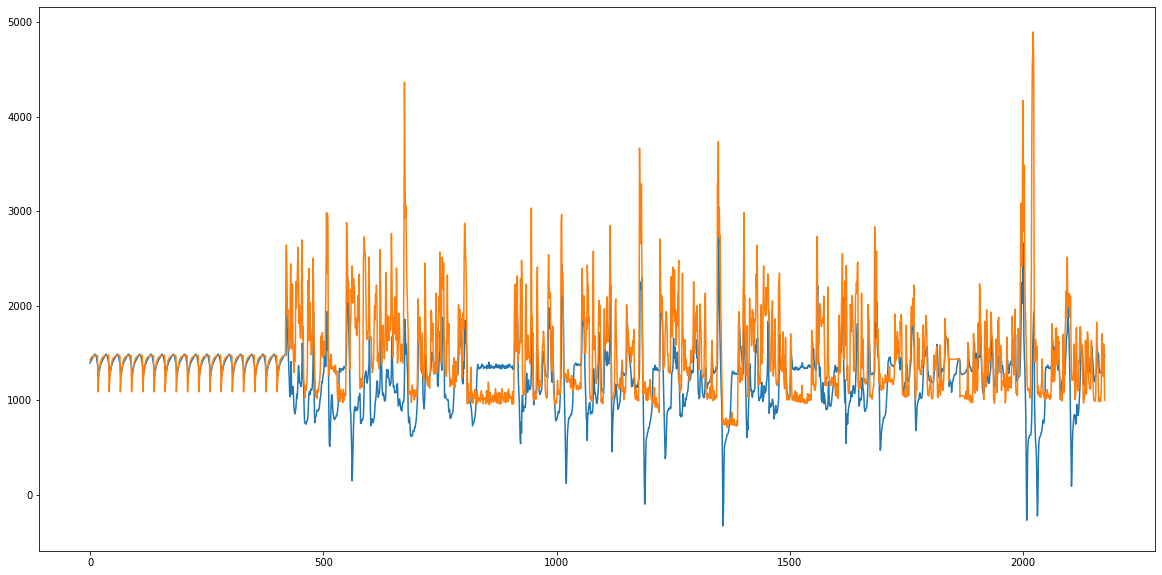

In [56]:
# plot
plt.figure(figsize=(20,10))
plt.plot(testPredict)
plt.plot(testY)
plt.show()

In [6]:
y_pred_list = []

# convert nparray
for k in range(10):
    nparr = df1.iloc[:, k].to_frame()
    nparr.astype('float32')
    print(nparr)

    # normalization
    scaler = MinMaxScaler(feature_range=(0, 1))
    nptf = scaler.fit_transform(nparr)
    
    # split train, test
    train_size = int(len(nptf) * 0.7)
    test_size = len(nptf) - train_size
    train, test = nptf[0:train_size], nptf[train_size:len(nptf)]
    print(len(train), len(test))

    look_back = 24  
    # look_back = timesteip = seq_length
    data_dim = 1
    # data_dim ( 들어오는 데이터 열 개수)
    # output_dim = 24 (hour: 나가게 하려는 값)
    def create_dataset(dataset, look_back):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i + look_back)]
            dataX.append(a)
            dataY.append(dataset[i + look_back])
        return np.array(dataX), np.array(dataY)

    # create dataset for learning
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (-1, look_back, data_dim))
    testX = np.reshape(testX, (-1, look_back, data_dim))


    # simple lstm network learning
    model = Sequential()
    model.add(LSTM(4, input_shape=(look_back, data_dim))) 
    #  앞의 숫자는 Unit 개수
    # input_shape = (data_size, time_steps, features)  그러나 모델을 돌릴 땐, data_size는 따로 넘기지 않음.
    # batch_input_sshape = (data_size, time_steps, features) 주의점 data_size % batch_size == 0
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)


    # make prediction
    testPredict = model.predict(testX)
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(testY)
    testScore = math.sqrt(mean_squared_error(testY, testPredict))
    print('Train Score: %.2f RMSE' % testScore)

    # predict last value (or tomorrow?)
    lastX = nptf[-24:]
    lastX = np.reshape(lastX, (-1, look_back, data_dim))
    lastY_pred = model.predict(lastX)
    lastY = scaler.inverse_transform(lastY_pred)
    print('Predict the Close value of final day: %d' % lastY)  # 
    lastY_pred





    # predict last value (or tomorrow?)
    
    number = 1
    lastY_pred = 0
    for i in range(look_back):
        lastX = nptf[-look_back: ]
        lastX = np.reshape(lastX, (-1, look_back, data_dim))
        lastY_pred = model.predict(lastX)
        lastY = (scaler.inverse_transform(lastY_pred))/1000
        nptf = np.concatenate((nptf, lastY_pred))

        print('Predict value of hour: {}'.format(lastY[0][0]))  # 데이터 입력 마지막 다음날 종가 예측
        globals()['y_pred_list{}'.format(k)].append(lastY[0][0])

                             X26
Time                            
2017-08-29 10:00:00  1453.803354
2017-08-29 11:00:00  1458.902776
2017-08-29 12:00:00  1462.694299
2017-08-29 13:00:00  1465.513373
2017-08-29 14:00:00  1467.609412
...                          ...
2018-06-30 19:00:00  1255.000000
2018-06-30 20:00:00  1596.000000
2018-06-30 21:00:00  1379.000000
2018-06-30 22:00:00  1000.000000
2018-06-30 23:00:00   976.000000

[7334 rows x 1 columns]
5133 2201
Train on 5108 samples
Epoch 1/5


UnknownError:  [_Derived_]  Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[sequential/lstm/StatefulPartitionedCall]] [Op:__inference_distributed_function_3016]

Function call stack:
distributed_function -> distributed_function -> distributed_function
